##Generating Natural Language Summaries from Factsheets

###Setup

In [1]:
DEBUG = False

In [2]:
!pip install openai
!pip install datasets
!pip install evaluate

In [3]:
!pip install rouge-score
!pip install bert-score
from rouge_score import rouge_scorer
from bert_score import score

In [4]:
import os
import json
import openai
from openai import OpenAI
import pandas
import re
from IPython import get_ipython
from IPython.utils.capture import capture_output

In [5]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CS 159 Project

from metrics_utils import *
from summary_utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1LeLbrNZayyv5i4FVOL44lq8EKgwzSuZl/CS 159 Project


###OpenAI Key

In [6]:
ipython = get_ipython() # run generated code
YOUR_KEY = input('Enter your OpenAI API Key: ')
client = OpenAI(api_key = YOUR_KEY)

pattern = re.compile(r'```python\n(.*?)```', re.DOTALL)  # extract code from llm generation

### Preprocessing

In [7]:
from datasets import load_dataset

def load_preprocess(DEBUG):
  # Load the dataset
  multi_lexsum = load_dataset("allenai/multi_lexsum", name="v20220616")
  train = multi_lexsum["test"] # The first instance of the dev set
  raw_data_train = []
  summaries_train = {"long": [], "short": [], "tiny": []}
  i = 0

  for case1 in train:
    # each case has 4-5 sources
    if DEBUG and i == 10:
      break
    raw_data_train.append(case1["sources"])

    for sum_len in ["long", "short", "tiny"]:
      summaries_train[sum_len].append(case1["summary/" + sum_len])
    if DEBUG:
      i += 1
  return raw_data_train, summaries_train

### Generating Natural Language Summaries from CSVs/Worksheets

In [8]:
import csv
from evaluate import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def process_csv(csv_file_path):
  csv_data = []
  with open(csv_file_path, newline='') as csvfile:
      csvreader = csv.reader(csvfile)
      for row in csvreader:
          csv_data.append(row)
  return csv_data


def generate_string(csv_data):
  csv_string = ''
  for i in range(len(csv_data)):
    if i == 0:
        continue
    else:
      csv_string += ': '.join(csv_data[i]) + '\n'
  return csv_string

### Main Loop

In [9]:
fact_sheet_path = 'factsheet/CJ-AL-0020_source.csv'
# def main(fact_sheet_path, DEBUG):
raw_data_train, summaries_train = load_preprocess(DEBUG)
  # return total_responses, ground_truth

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
def main(fact_sheet_path, DEBUG):
  raw_data_train, summaries_train = load_preprocess(DEBUG)
  total_responses = {}
  len_dict = {"tiny": 25, "short": 130, "long": 650}
  processed_csv = generate_string(process_csv(fact_sheet_path))
  for sum_size in len_dict:
    print("Summarizing " + str(sum_size) + " summaries")
    num_words = len_dict[sum_size]
    ground_truth = summaries_train[sum_size][0]
    # Execute the chain of density prompting
    inital_prompt = f"Summarize the factsheet so that it is understandable to the general public in exactly {num_words} words"
    best_responses = chain_of_density_prompting(processed_csv, inital_prompt, client, ground_truth, num_words)
    total_responses[sum_size] = best_responses
  return total_responses, ground_truth

In [11]:
fact_sheet_path = 'factsheet/CJ-AL-0020_source.csv'
total_responses, ground_truth = main(fact_sheet_path, DEBUG)

Summarizing tiny summaries
Summarizing short summaries
Summarizing long summaries


In [18]:
def debug_chain_of_density(total_responses, ground_truth):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  for sum_size in total_responses:
    responses = total_responses[sum_size]
    for response in responses:
        rouge_scores = scorer.score(response, ground_truth)
        print("Rouge Scores: ", rouge_scores)
        P, R, F1 = score([response], [ground_truth], lang="en", verbose=True)
        print("Bert Score Precision: ", P.item())
        print("Bert Score Recall: ", R.item())
        print("Bert Score F1: ", F1.item())

if DEBUG:
  debug_chain_of_density(total_responses, ground_truth)


###Computing Rouge and Bert F1 Scores For All Granularities

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import numpy as np

def find_scores(total_responses):
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  total_scores = {}
  for sum_size in total_responses:
    scoring = {}
    print("Evaluating " + str(sum_size) + " summaries")
    responses = total_responses[sum_size]
    response = responses[-1]
    rouge_scores = scorer.score(response, ground_truth)
    for rouge_type in rouge_scores:
      scoring[rouge_type] = rouge_scores[rouge_type].fmeasure
    P, R, F1 = score([response], [ground_truth], lang="en", verbose=True)
    scoring["bert"] = F1.item()
    total_scores[sum_size] = scoring
  return total_scores


def create_table(total_scores):
  table_df = pd.DataFrame(total_scores)
  df = table_df.transpose()
  df = np.round(df, 4)
  df.columns = ['Rouge1', 'Rouge2', 'RougeL', 'Bert']

  fig, ax = plt.subplots(figsize=(10, 4))
  ax.axis('off')

  tab = table(ax, df, loc='center', cellLoc='center')

  plt.title("Rouge and Bert F1 Scores Across All Granularities")
  plt.tight_layout(pad=1.0)

  plt.subplots_adjust(top=0.85)
  plt.show()

In [20]:
total_scores = find_scores(total_responses)

Evaluating tiny summaries


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.18 sentences/sec
Evaluating short summaries


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.77 sentences/sec
Evaluating long summaries


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.15 sentences/sec


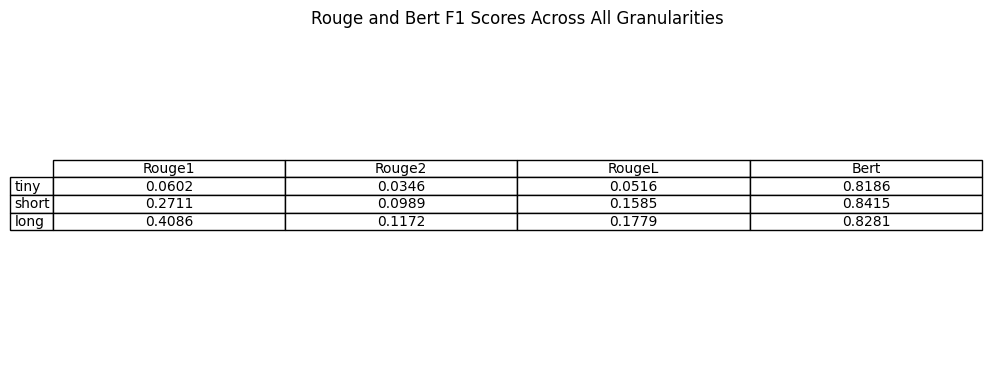

In [21]:
create_table(total_scores)

###CSV Creation

In [22]:
courtcase = fact_sheet_path.split("/")[1]
courtcase_name = courtcase.split("_source.csv")[0]

In [23]:
tiny_summary = total_responses["tiny"][-1]
short_summary = total_responses["short"][-1]
long_summary = total_responses["long"][-1]

data = {
    'Granularity': ['tiny', 'short', 'long'],
    'Best Summary': [tiny_summary, short_summary, long_summary]
}

df = pd.DataFrame(data)

csv_file_path = 'LegalSumAI_summaries.csv'
df.to_csv(csv_file_path, index=False)

try:
    with open(csv_file_path, 'r') as f:
        existing_content = f.read()
except FileNotFoundError:
    existing_content = ""

# Write the new content to the file
with open(csv_file_path, 'w') as f:
    f.write(f"Legal Summaries for Case {courtcase_name}\n")
    f.write(existing_content)

print("CSV Summary Generation Complete")

CSV Summary Generation Complete
